Import basic libraries for data science

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Import objects from FCApy

In [2]:
from fcapy.context import FormalContext, converters
from fcapy.lattice import ConceptLattice
from fcapy.visualizer import Visualizer
from fcapy.algorithms import lattice_construction as lca

# Motivation for the task

FCApy package grows big. It has 7 subpackages with their own modules, classes and functions. Some of these subpackages intersect, e.g. class ``ConceptLattice`` from subpackage ``lattice`` uses (imports) functions from the module ``lattice_construction`` of subpackage ``algorithms``.

It would be nice to have a visualiztion of all these 'import' relations so that on can see which python object (module, class or function) is closer to 'front-end' (i.e. it uses a lot of other objects) and which is closer to 'back-end' (i.e. it is used by a lot of other objects).

The standard way to do so is to manualy construct a block diagram representing all these relations. This way takes a lot of time and the resulting diagram has to be reconstructed after each modification of a source code of the package.

We will try do in an automatic way using ``FCApy`` to visualize the import relations in the source code of ``FCApy``.

# Part 1. Parsing the code

We want to automatically parse the source code and get a dictionary of the form {name of python object X: names of python objects imported by X}

// This part has nothing to do with FCA

In [3]:
RE_PATTERNS = {
    'from_import': r"\s*from\s+([\w\.]+)\s+import\s+([\w\s,]+).*",
    'import': r"\s*import\s+([\w\.\s,]+).*",
    'class_or_func_def': r'\s*(?:def|class)\s+(\w+).*',
    'condition_block': r'\s*(?:if|elif|else).*:',
}

In [4]:
def get_last_argmax(array, val):
    return max(np.arange(len(array))[array==val])

In [5]:
def get_importer_parent_name(lines, importer_line_idx):
    indents = np.array([len(re.match(r'(\s*)', line).groups()[0])
                        for line in  lines[:importer_line_idx+1]])
    if indents[-1] == 0:
        return ''
    
    main_parent_line_idx = get_last_argmax(indents, 0)    
    parent_line_idxs = np.array([
        main_parent_line_idx+get_last_argmax(indents[main_parent_line_idx:], ind)
        for ind in sorted(set(indents[main_parent_line_idx:]))
        if ind < indents[-1]
    ])
    parent_lines = np.array(lines)[parent_line_idxs]

    def is_valid_parent(line):
        pattern_names = ['class_or_func_def', 'condition_block']
        parent_patterns = [RE_PATTERNS[ptrn_name] for ptrn_name in pattern_names]
        return any([re.match(ptrn, line) for ptrn in parent_patterns])
    assert all([is_valid_parent(p) for p in parent_lines]),\
        'Selected parent objects are neither function nor class definitions'
    
    parents = [re.match(RE_PATTERNS['class_or_func_def'], line)for line in parent_lines]
    parents = [p for p in parents if p is not None]    
    parents = [p.groups()[0] for p in parents]
    return '.'.join(parents)

In [6]:
def get_imports_from_file_string(file_string, file_name_rel=''):
    def join_subpackages(superpackage: str, subpackage: str):
        return f"{superpackage}.{subpackage}".strip('.')
    
    def parse_line_to_import(line_idx, line):
        line_type = None
        for ptrn_name in ['from_import', 'import']:
            if re.match(RE_PATTERNS[ptrn_name], line):
                line_type = ptrn_name 

        if line_type is None:
            return None

        imported_objects = re.match(RE_PATTERNS[line_type], line).groups()
        if line_type == 'from_import':
            imported_from, imported_objects = imported_objects
        else:
            imported_objects = imported_objects[0]
            imported_from = ''

        imported_objects = re.sub(r'\bas\s+\w+', '', imported_objects)
        imported_objects = re.sub(r'\s+', '', imported_objects)
        imported_objects = imported_objects.split(',')
        
        importer = join_subpackages(file_name_rel, get_importer_parent_name(file_lines, line_idx))
        imported = {join_subpackages(imported_from, imported_object)
                    for imported_object in imported_objects}
        
        return importer, imported
    
    
    file_name_rel = file_name_rel.replace('/','.')
    file_lines = file_string.split('\n')
    
    import_lines = [parse_line_to_import(line_idx, line)
                    for line_idx, line in enumerate(file_lines)]
    import_lines = [imp for imp in import_lines if imp is not None]
    
    importers_all = set(imp[0] for imp in import_lines)
    import_dict = {}
    for importer in importers_all:
        imported_flat = {imported_
                         for importer_, imported_set in import_lines
                         for imported_ in imported_set
                         if importer_ == importer}
        import_dict[importer] = imported_flat
    
    import_dict = {k:v|import_dict.get(file_name_rel, set()) for k,v in import_dict.items()}
    
    return import_dict

In [7]:
def preprocess_file_data(file_data):
    patterns_to_sub = [
        (r'#.*?__NL__', '__NL__'),       # Drop one line comments
        (r'""".*?"""', ' '),                 # Drop any """ """ string literals
        (r'".*?"', ' '),                 # Drop any " " string literals
        (r"'.*?'", ' '),                 # Drop any ' ' string literals
        (r"print\(.*?\)", ' '),          # Drop print statements
        (r'\\\s*__NL__', ''),            # Drop slashes to a new line
        (r"__NL__\s*__NL__", '__NL__'),  # Drop empty lines
    ]
    
    file_data = file_data.replace('\n','__NL__')  # Prepare to work with regexp
    for pattern, sub in patterns_to_sub:
        file_data_new = None
        while file_data_new != file_data:
            file_data = file_data if file_data_new is None else file_data_new
            file_data_new = re.sub(pattern, sub, file_data)  # Replace regexp patterns
        file_data = file_data_new
    file_data = file_data.replace('__NL__', '\n')  # Go back to original format
    return file_data

Load the source code of FCApy files

In [8]:
python_file_names = os.popen('find fcapy -type f | grep ".py$"').read().strip().split('\n')

python_file_data = {}
for fname in python_file_names:
    with open(fname, 'r') as f:
        data = f.read()

    python_file_data[fname[:-3]]= data

Parse each file to get the source code

In [9]:
pdata_imports_all = {}
for pname, pdata in python_file_data.items():
    pname_clean = pname.replace('/','.')
    pdata_clean = preprocess_file_data(pdata)
    
    pdata_imports = get_imports_from_file_string(pdata_clean, pname_clean)
    
    assert set(pdata_imports_all)&set(pdata_imports) == set()
    pdata_imports_all = dict(pdata_imports_all, **pdata_imports)

Fill dictionary with the idea that python object `a.b` automaticaly imports an object `a.b.c`

In [10]:
import_keys = sorted(set(pdata_imports_all))
for k in import_keys:
    k_splitted = k.split('.')
    for i in range(1, len(k_splitted)):
        k_join = '.'.join(k_splitted[:i])
        k_join_sub = '.'.join(k_splitted[:i+1])
        pdata_imports_all[k_join] = pdata_imports_all.get(k_join, set()) | {k_join_sub,}

If `a` is a subpackage and has an init file `a.__init__` then all the object imported in `a.__init__` will imported in all the subobjects `a.b`

In [11]:
init_imports = [k for k in pdata_imports_all if k.endswith('__init__')]
for init in init_imports:
    pkg_name = '.'.join(init.split('.')[:-1])
    subpackages = [k_ for k_ in pdata_imports_all if k_.startswith(pkg_name)]
    for k_ in subpackages:
        pdata_imports_all[k_] |= pdata_imports_all[init]

Turn the dictionary into Pandas.DataFrame

In [12]:
imports_df = pd.DataFrame({k:{v:True for v in vs} for k,vs in pdata_imports_all.items()}).fillna(False)
print(imports_df.shape)
imports_df.head()

(86, 47)


,fcapy.algorithms.concept_construction.sofia_binary,fcapy.algorithms.concept_construction,fcapy.algorithms.concept_construction.random_forest_concepts,fcapy.algorithms.concept_construction.parse_decision_tree_to_extents,fcapy.algorithms.lattice_construction.add_concept,fcapy.algorithms.lattice_construction,fcapy.algorithms.lattice_construction.complete_comparison,fcapy.algorithms.lattice_construction.construct_lattice_from_spanning_tree,fcapy.algorithms.lattice_construction.remove_concept,fcapy.algorithms.lattice_construction.construct_lattice_from_spanning_tree_parallel,...,fcapy,fcapy.algorithms,fcapy.context,fcapy.context.formal_context.FormalContext,fcapy.lattice,fcapy.ml,fcapy.mvcontext,fcapy.utils,fcapy.visualizer,fcapy.visualizer.visualizer.Visualizer
random,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
fcapy.mvcontext.mvcontext.MVContext,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
copy.deepcopy,True,True,True,True,True,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
fcapy.algorithms.lattice_construction,True,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
fcapy.lattice.formal_concept.FormalConcept,True,True,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


This dataframe represents import relations in the package.

For example:

In [13]:
g, m = 'fcapy.lattice.formal_concept.FormalConcept', 'fcapy.algorithms.concept_construction.sofia_binary'
x = imports_df.loc[g, m]
print(f'Does `{g}` is imported by `{m}`?', 'Yes' if x else 'No')

Does `fcapy.lattice.formal_concept.FormalConcept` is imported by `fcapy.algorithms.concept_construction.sofia_binary`? Yes


# Part 2. Apply FCA to get the hierarchy of objects

## Part 2.1 Create FormalContext and ConceptLattice

First we need to apply transitive closure to the dataset. The reason is that the import relation we study is transitive: if `a` is imported by `b` and `b` is imported by `c` then `a` is imported by `c`.

In [14]:
def transitive_closure(df):
    df_trans = df.copy()
    for f in df.columns:
        if f not in df_trans.index:
            df_trans.loc[f] = None
    for f in df.index:
        if f not in df_trans.columns:
            df_trans[f] = None
    df_trans = df_trans.fillna(False).astype(bool)
    df_trans = df_trans[df_trans.index]
    
    df_trans |= np.eye(len(df_trans), dtype=bool)

    df_trans_new = None
    while not (df_trans_new == df_trans).all().all():
        df_trans = df_trans if df_trans_new is None else df_trans_new
        df_trans_new = df_trans | df_trans.dot(df_trans)

    df_trans = df_trans_new
    df_trans_red = df_trans.loc[df.index, df.columns]
    return df_trans_red, df_trans

Apply transitive closure to our data

In [15]:
imports_df_trans, imports_df_trans_full = transitive_closure(imports_df)

Construct a `FormalContext` and `ConceptLattice` out of transitively closed dataset

In [16]:
ctx_full = FormalContext.from_pandas(imports_df_trans_full)
ltc_full = ConceptLattice.from_context(ctx_full)
len(ltc_full.concepts)

114

In [17]:
c = ltc_full.concepts[50]
print('extent', c.extent)
print('intent', c.intent)

extent ('fcapy.mvcontext.mvcontext.MVContext', 'warnings', 'fcapy.lattice.ConceptLattice', 'fcapy.ml', 'fcapy.ml.decision_lattice')
intent ('fcapy.ml', 'fcapy')


The concept number 50 shows that all the objects from `intent` (`fcapy.algorithms.concept_construction`, `fcapy.<___>.random_forest_concepts`, e.t.c) import all the 5 objects from `extent` (`math`, `warnings`, `fcapy.LIB_INSTALLED`, `numpy`, `collections.abc.Iterable`)

We obtain 114 concept from the full imports dataset. The set of concepts is too big to be analyzed easily so let us simplify the underlying context a bit.

Drop `__init__` files from the context to make analysis a little easier

In [18]:
no_init_objs, no_init_attrs = [
    [x_i for x_i, x in enumerate(ar) if not x.endswith('__init__')]
    for ar in [ctx_full.object_names, ctx_full.attribute_names]]
ctx_no_init_trans = ctx_full[no_init_objs][:,no_init_attrs]

Drop all non FCApy python objects from the context (e.g. `numpy`, `sklearn`) to make analysis a little bit easier

In [19]:
only_fca_objs, only_fca_attrs = [
    [x_i for x_i, x in enumerate(ar) if x.startswith('fca')]
    for ar in [ctx_no_init_trans.object_names, ctx_no_init_trans.attribute_names]]
ctx_only_fca_trans = ctx_no_init_trans[only_fca_objs][:, only_fca_attrs]

Compute the concept lattice on the simplified context

In [20]:
ltc = ConceptLattice.from_context(ctx_only_fca_trans)
len(ltc.concepts)

53

## Part 2.2. Visualize the ConceptLattice

Next we create a `draw_networkx` function to draw a concept lattice of import relations. This function is a bit modified version of the function `fcapy.visualizer.Visualizer.draw_networkx`.

In [21]:
import networkx as nx
def draw_networkx(vsl, draw_node_indices=False, edge_radius=None, max_new_extent_count=3, max_new_intent_count=3):
    self = vsl
    
    graph = nx.DiGraph(self._lattice.subconcepts_dict)
    cs = f'arc3,rad={edge_radius}' if edge_radius is not None else None
    nx.draw_networkx_edges(graph, self._pos, edge_color='lightgrey', arrowstyle='-', connectionstyle=cs)
    nx.draw_networkx_nodes(
        graph, self._pos,
        node_color=self.node_color, cmap=self.cmap, alpha=self.node_alpha,
        linewidths=self.node_linewidth, edgecolors=self.node_edgecolor,
        vmin=self.cmap_min, vmax=self.cmap_max
    )
    
    def shorted_name(x):
        shortens = {
            'algorithms': 'algos',
            'lattice': 'ltc',
            'mvcontext': 'mvctx',
            'context': 'ctx',
            'concept_lattice': 'cltc',
            'visualizer': 'vsl',
            'Visualizer': 'Vsl',
            'converters': 'convs',
            'concept_construction': 'cca',
            'lattice_construction': 'lca',
            'FormalContext': 'FCtx',
            'formal_concept': 'fcncpt',
            'pattern_concept': 'pcncpt',
        }
        for k,v in shortens.items():
            x = re.sub(r"\b"+k+r"\.", v+'.', x)
        return x

    labels = {}
    for c_i in range(len(self._lattice.concepts)):
        new_extent = sorted(list(self._lattice.get_concept_new_extent(c_i)))
        i = 0
        while i < len(new_extent):
            g = new_extent[i]
            new_extent = [g_ for g_ in new_extent if not g_.startswith(g) or g_==g]
            i += 1
        new_extent = ['.'.join(g.split('.')[-2:]) for g in new_extent]
        new_extent = [shorted_name(g) for g in new_extent]
                
        new_intent = sorted(list(self._lattice.get_concept_new_intent(c_i)))
        i = 0
        while i < len(new_intent):
            m = new_intent[i]
            new_intent = [m_ for m_ in new_intent if not m_.startswith(m) or m_==m]
            i += 1
        new_intent = ['.'.join(m.split('.')[-2:]) for m in new_intent]
        new_intent = [shorted_name(m) for m in new_intent]
        
        new_extent = [g for g in new_extent if g not in new_intent]
        
        if len(new_extent) > 0:
            new_extent_str = f"{len(new_extent)}: "+', '.join(new_extent[:max_new_extent_count])
            new_extent_str += '...' \
                if max_new_extent_count is not None and len(new_extent) > max_new_extent_count else ''
        else:
            new_extent_str = ''
        if len(new_intent) > 0:
            new_intent_str = f"{len(new_intent)}: "+', '.join(new_intent[:max_new_intent_count])
            new_intent_str += '...'\
                if max_new_intent_count is not None and len(new_intent) > max_new_intent_count else ''
        else:
            new_intent_str = ''

        labels[c_i] = '\n\n'.join([new_intent_str, new_extent_str])

    nx.draw_networkx_labels(graph, self._pos, labels, horizontalalignment='left')

    if draw_node_indices:
        nx.draw_networkx_labels(graph, self._pos)

### Part 2.2.1 Visualize the whole concept lattice

We reduced the number of concepts from 114 to 53. Now let us look at the hierarcy of concepts.

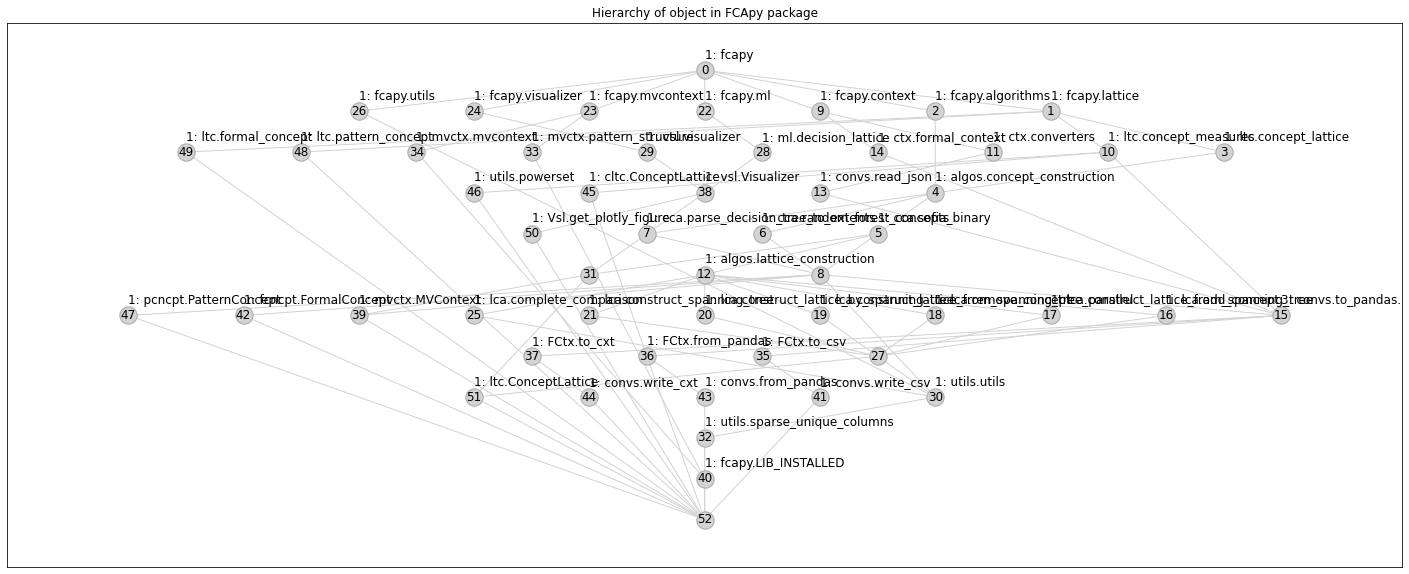

In [22]:
vsl = Visualizer(ltc)
vsl.node_color = 'lightgrey'
vsl.node_edgecolor = 'darkgrey'

plt.figure(figsize=(25,10))
draw_networkx(vsl, draw_node_indices=True, max_new_intent_count=1, max_new_extent_count=0)
plt.title('Hierarchy of object in FCApy package')
plt.show()

On the concept lattice above we can see the `fcapy` package at the top. It consists of 7 subpackages: `fcapy.utils`, `fcapy.visualizer`, `fcapy.ml`, `fcapy.mvcontext`, `fcapy.context`, `fcapy.algorithms`, `fcapy.lattice`. Which, in turn, consist of some other python objects.

The number of objects is too big and the concept lattice looks too noisy so we cannot read much from it. Let us select only the most stable concepts from the lattice with LStab interest measure: Lower estimation of concept stability.

In [23]:
n_best_concepts = 10

ltc.calc_concepts_measures('LStab')
stabs = [c.measures['LStab'] for c in ltc.concepts]
min_stab_threshold = sorted(stabs)[-n_best_concepts]
concepts_stab = [c for c in ltc.concepts if c.measures['LStab']>=min_stab_threshold]
print(len(concepts_stab))
subconcepts_dict = lca.complete_comparison(concepts_stab)
ltc_stab = ConceptLattice(concepts_stab, subconcepts_dict=subconcepts_dict)

10


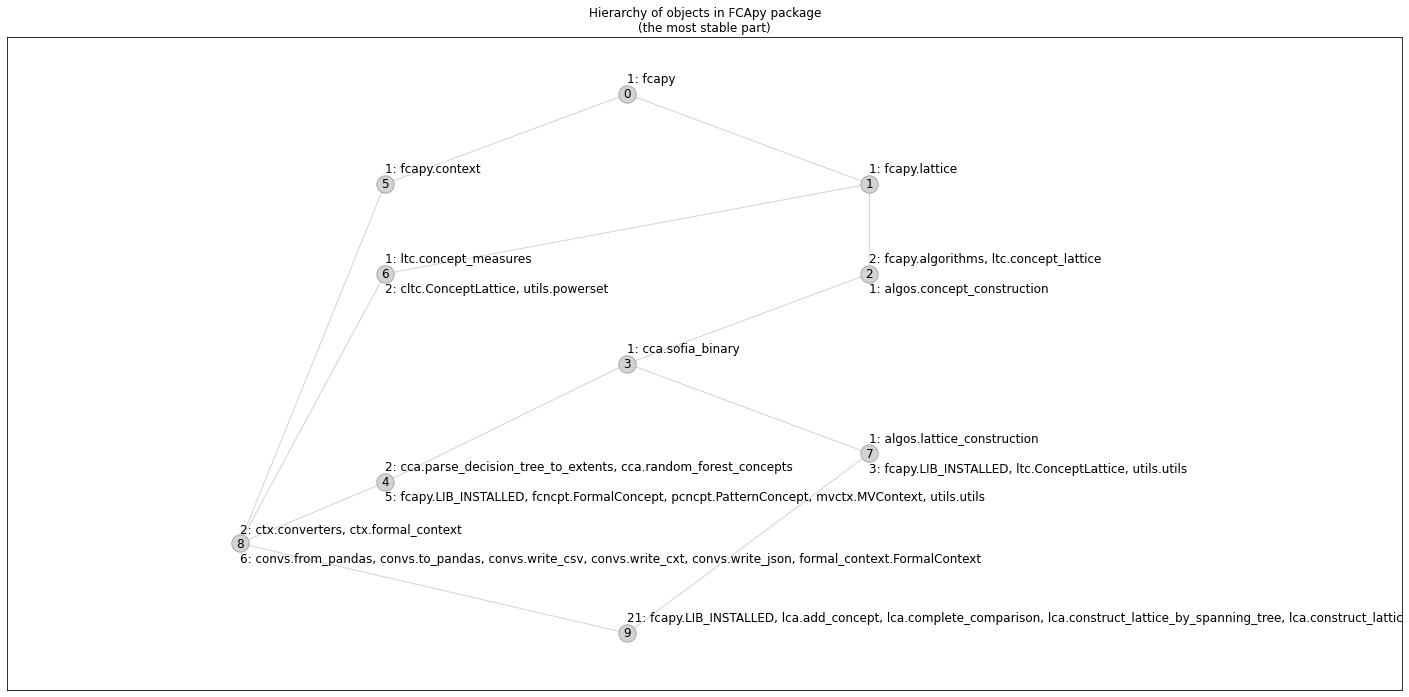

In [24]:
vsl = Visualizer(ltc_stab)
vsl.node_color = 'lightgrey'
vsl.node_edgecolor = 'darkgrey'

vsl._pos[4], vsl._pos[7] = vsl._pos[7], vsl._pos[4]
vsl._pos[4][1] -= 0.1
vsl._pos[8][0] -= 0.25


plt.figure(figsize=(25,12))
draw_networkx(vsl, draw_node_indices=True, max_new_intent_count=None, max_new_extent_count=None, edge_radius=0)
plt.xlim(-0.4,0.5)
plt.title('Hierarchy of objects in FCApy package\n(the most stable part)')
plt.show()

This concept lattice looks less noisy.

We can see that the main part of `fcapy` package is two submodules: `fcapy.context` and `fcapy.lattice`. But the plot is still unreadable.

### Part 2.2.1 Visualize the concept lattice of a single subpackage

What if we try to look at the structure of a single subpackage?

#### Subpackage `fcapy.context`

In [25]:
m = 'fcapy.context'
m_i = np.argmax(np.array(ctx_only_fca_trans.attribute_names)==m)
ext_ = ctx_only_fca_trans.extension_i([m_i])
int_ = list(set([m_ for g_ in ext_ for m_ in ctx_only_fca_trans.intention_i([g_])]))

In [26]:
ctx_cur = ctx_only_fca_trans[ext_][:,int_]
ltc_cur = ConceptLattice.from_context(ctx_cur)
print(len(ltc_cur.concepts))

12


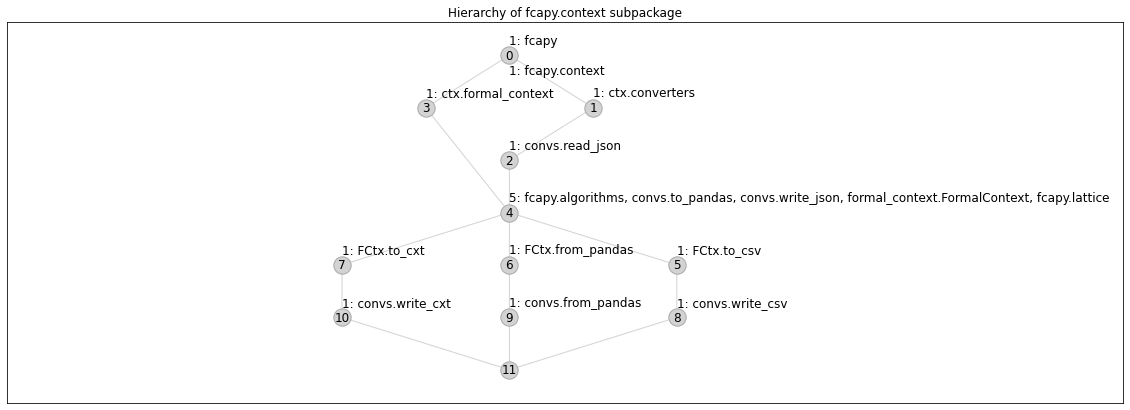

In [27]:
plt.figure(figsize=(20,7))
vsl_cur = Visualizer(ltc_cur)
vsl_cur.node_color = 'lightgrey'
vsl_cur.node_edgecolor = 'darkgrey'
#vsl_cur._pos[16][0] += 0.2
draw_networkx(vsl_cur, max_new_intent_count=5, draw_node_indices=True)
plt.xlim(-0.9,1.1)
plt.title(f'Hierarchy of {m} subpackage')
plt.show()

Takeaways:
* Subpackage `fcapy.context` (node 0) consists of 2 modules: `context.formal_context` (node 2) and `context.converters` (node 1), which both use subpackages `fcapy.algorithms`, `fcapy.lattice` (node 4).
* They both use the class `fcapy.formal_context.FormalContext` too (node 4).
* The class itself is the only user of functions `fcapy.converters.write_cxt`, `fcapy.converters.write_csv`, `fcapy.converters.from_pandas` (pairs of nodes 7-10, 6-9, 5-8).

#### Subpackage `fcapy.ml`

In [28]:
m = 'fcapy.ml'
m_i = np.argmax(np.array(ctx_only_fca_trans.attribute_names)==m)
ext_ = ctx_only_fca_trans.extension_i([m_i])
int_ = list(set([m_ for g_ in ext_ for m_ in ctx_only_fca_trans.intention_i([g_])]))

In [29]:
ctx_cur = ctx_only_fca_trans[ext_][:,int_]
ltc_cur = ConceptLattice.from_context(ctx_cur)
print(len(ltc_cur.concepts))

6


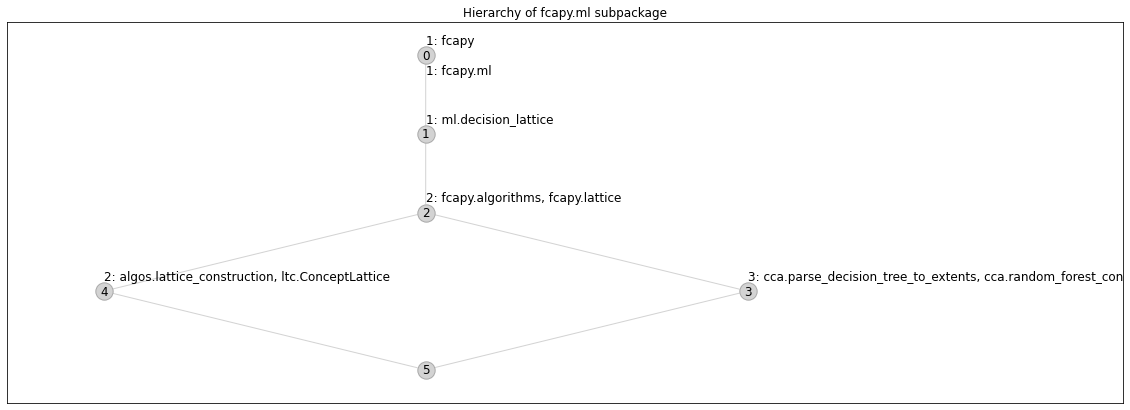

In [30]:
plt.figure(figsize=(20,7))
vsl_cur = Visualizer(ltc_cur)
vsl_cur.node_color = 'lightgrey'
vsl_cur.node_edgecolor = 'darkgrey'
#vsl_cur._pos[16][0] += 0.2
draw_networkx(vsl_cur, max_new_intent_count=5, draw_node_indices=True)
plt.xlim(-0.3,0.5)
plt.title(f'Hierarchy of {m} subpackage')
plt.show()

Takeaways:
* Subpackage `fcapy.ml` (node 0) consists only on a module `fcapy.ml.decision_lattice` (node 1) which import `fcapy.algorithms` and `fcapy.lattice` (node 2).
* The specific algorithms are `fcapy.algorithms.concept_construction.parse_decision_tree_to_extents`, `fcapy.algorithms.concept_construction.random_forest_concepts` which work with many valued context `MVContext` (node 4).
* The other algorithms used are some of `fcapy.algorithms.lattice_construction` (node 3).

#### Subpackage `fcapy.lattice`

In [31]:
m = 'fcapy.lattice'
m_i = np.argmax(np.array(ctx_only_fca_trans.attribute_names)==m)
ext_ = ctx_only_fca_trans.extension_i([m_i])
int_ = list(set([m_ for g_ in ext_ for m_ in ctx_only_fca_trans.intention_i([g_])]))

In [32]:
ctx_cur = ctx_only_fca_trans[ext_][:,int_]
ltc_cur = ConceptLattice.from_context(ctx_cur)
print(len(ltc_cur.concepts))

37


We get too much concepts again. Let us select only the most stable ones.

In [33]:
n_best_concepts = 8

ltc_cur.calc_concepts_measures('LStab')
stabs = [c.measures['LStab'] for c in ltc_cur.concepts]
min_stab_threshold = sorted(stabs)[-n_best_concepts]
concepts_stab_cur = [c for c in ltc_cur.concepts if c.measures['LStab']>=min_stab_threshold]
print(len(concepts_stab_cur))
subconcepts_dict = lca.complete_comparison(concepts_stab_cur)
ltc_stab_cur = ConceptLattice(concepts_stab_cur, subconcepts_dict=subconcepts_dict)

8


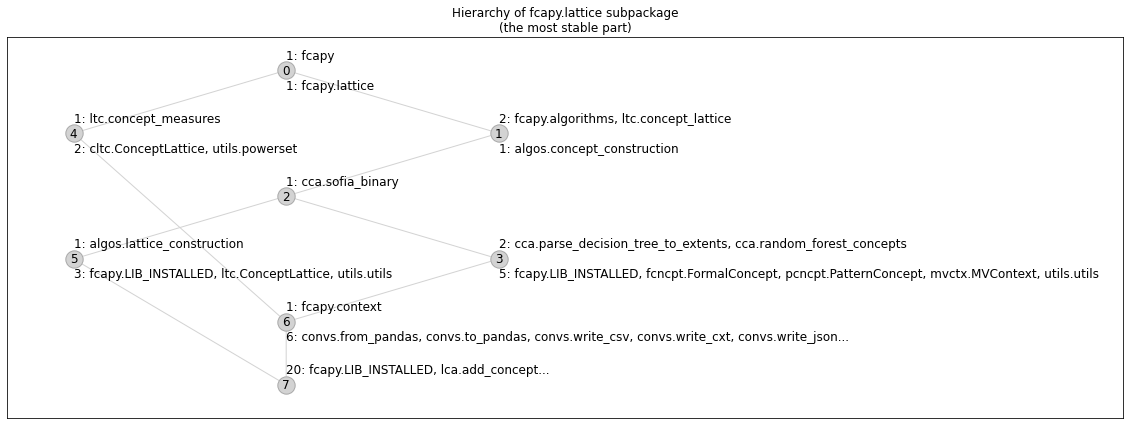

In [34]:
plt.figure(figsize=(20,7))
vsl_cur = Visualizer(ltc_stab_cur)
vsl_cur.node_color = 'lightgrey'
vsl_cur.node_edgecolor = 'darkgrey'
#vsl_cur._pos[16][0] += 0.2
draw_networkx(vsl_cur, max_new_intent_count=2, max_new_extent_count=5, draw_node_indices=True)
plt.xlim(-0.25,0.75)
plt.title(f'Hierarchy of {m} subpackage\n(the most stable part)')
plt.show()

Again, the more concepts we have the more messed up the plot is.

# Part 3. Conclusions

The idea of automatic visualization of a code structure looks very promising but the current results are not.

* First, to make a good visualization one has to have a good parser of the source code.
* Second, we have to do something with the way concept lattices are visualized. The visualization should be more compact and easy to read